In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list, start = start_date, end = end_date)
df = df.stack(level=1)
df.index.names = ['date', 'ticker']
print(df.head())

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['VLTO', 'GEV', 'SW', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price              Adj Close      Close       High        Low       Open  \
date       ticker                                                          
2015-09-29 A             NaN  31.185347  31.481117  30.723205  30.834118   
           AAPL          NaN  24.536379  25.537543  24.266403  25.384557   
           ABBV          NaN  35.061218  35.991046  34.456829  35.267107   
           ABT           NaN  32.820740  33.360829  32.430213  32.621321   
           ACGL          NaN  23.217773  23.255808  22.916655  22.983217   

Price                   Volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  


In [3]:
df['garman_klass_vol'] = (((np.log(df['High']) - np.log(df['Low']))**2)/2) - ((2*np.log(2)-1)*(np.log(df['Close'])-np.log(df['Open']))**2)
df['rsi'] = df.groupby(level=1)['Close'].transform(lambda x: pandas_ta.rsi(close = x, length=20))

def compute_bbands(group):
    bands = pandas_ta.bbands(close=np.log1p(group['Close']), length=20)
    return group.assign(
        bb_low=bands['BBL_20_2.0'],
        bb_mid=bands['BBM_20_2.0'],
        bb_high=bands['BBU_20_2.0']
    )
df = df.groupby(level=1, group_keys=False).apply(compute_bbands)
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['High'], low = stock_data['Low'], close = stock_data['Close'], length =14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr']= df.groupby(level=1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close = close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['Close'].apply(compute_macd)


df['dollar_volume'] = (df['Close']*df['Volume'])/1e6

df


Price              Adj Close       Close        High         Low        Open  \
date       ticker                                                              
2015-09-29 A             NaN   31.185347   31.481117   30.723205   30.834118   
           AAPL          NaN   24.536379   25.537543   24.266403   25.384557   
           ABBV          NaN   35.061218   35.991046   34.456829   35.267107   
           ABT           NaN   32.820740   33.360829   32.430213   32.621321   
           ACGL          NaN   23.217773   23.255808   22.916655   22.983217   
...                      ...         ...         ...         ...         ...   
2023-09-26 XYL           NaN   87.701073   89.004051   87.681482   88.543599   
           YUM           NaN  119.860703  120.566273  119.319435  120.083003   
           ZBH           NaN  110.513580  115.083101  110.474272  114.748982   
           ZBRA          NaN  223.960007  226.649994  222.580002  225.970001   
           ZTS           NaN  173.604691  175.155523  173.015777  173.320051   

Price                   Volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0          0.000247        NaN       NaN   
           AAPL    293461600.0          0.000857        NaN       NaN   
           ABBV     12842800.0          0.000936        NaN       NaN   
           ABT      12287500.0          0.000386        NaN       NaN   
           ACGL      1888800.0          0.000068        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000077  26.146755  4.474158   
           YUM       1500600.0          0.000053  36.057161  4.792447   
           ZBH       3610500.0          0.000289  31.893265  4.736766   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000075  42.623461  5.145043   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.241875  
           AAPL         NaN       NaN       NaN       NaN    7200.484999  
           ABBV         NaN       NaN       NaN       NaN     450.284214  
           ABT          NaN       NaN       NaN       NaN     403.284840  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.556072  4.637985  0.117087 -2.159188     115.975899  
           YUM     4.822408  4.852369  0.273235 -1.363696     179.862970  
           ZBH     4.776429  4.816093 -0.317023 -0.881067     399.009282  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.203852  5.262662  0.688219 -1.188278     254.018383  

[979418 rows x 14 columns]

<Axes: xlabel='date'>

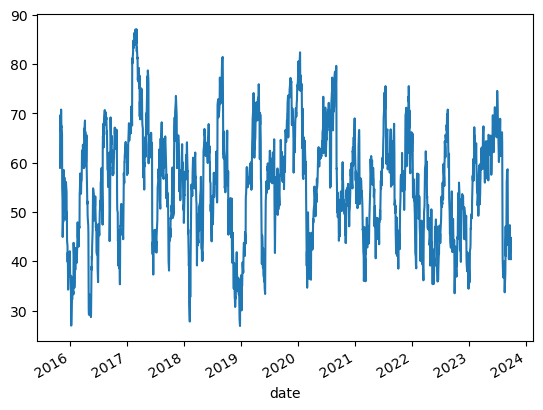

In [4]:
df.xs('AAPL', level=1)['rsi'].plot()

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','Volume', 'Open', 'High','Low', 'Adj Close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
        ,df.unstack()[last_cols].resample('M').last().stack('ticker')],
        axis=1).dropna()

data

dollar_volume       Close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.704646   38.653545          0.000050  73.421533   
           AAPL      4005.252669   26.729132          0.000095  55.537335   
           ABBV       325.730952   38.977573          0.000362  49.376864   
           ABT        207.499343   37.541000          0.000043  56.962762   
           ACGL        28.174423   22.970539          0.000078  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 EXE        116.689767   79.277855          0.000084  44.326494   
           COIN       506.793576   70.519997          0.001007  39.839731   
           CEG        195.364203  107.145668          0.000274  55.245465   
           GEHC       211.929505   66.022316          0.000185  40.922315   
           KVUE       646.494244   19.281166          0.000158  35.706317   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.536749  3.609179  3.681609 -1.042158  0.567157  
           AAPL    3.277189  3.320493  3.363797 -0.976120 -0.142790  
           ABBV    3.691885  3.740093  3.788301 -0.758487  0.145678  
           ABT     3.636725  3.658567  3.680410 -1.097933  0.335557  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 EXE     4.369459  4.422967  4.476475 -0.890969 -0.831787  
           COIN    4.273572  4.378785  4.483998 -1.183735  0.049978  
           CEG     4.645547  4.685718  4.725889 -0.396676  0.366876  
           GEHC    4.153828  4.211363  4.268898 -0.892836 -1.116463  
           KVUE    2.979201  3.054020  3.128840 -0.872134 -1.435622  

[46244 rows x 9 columns]

In [6]:
data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis =1)

data

Close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2020-10-31 AAPL    106.010231          0.000601  43.770315  4.681436   
           ABBV     71.141037          0.000492  47.517595  4.230616   
           ABT      96.892754          0.000265  48.047134  4.581505   
           ACN     202.907425          0.000165  42.280844  5.305017   
           ADBE    447.100006          0.000472  39.586497  6.119939   
...                       ...               ...        ...       ...   
2023-09-30 WDAY    229.240005          0.000141  43.976804  5.437299   
           WFC      38.847340          0.000234  40.920273  3.673898   
           WMT      53.052738          0.000024  54.722557  3.974950   
           XOM     109.552101          0.000045  59.440196  4.653137   
           ZTS     173.604691          0.000075  42.623461  5.145043   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2020-10-31 AAPL    4.740252  4.799068  1.386833 -0.628203  
           ABBV    4.273986  4.317357 -0.130545 -0.994069  
           ABT     4.608834  4.636162  0.962562 -0.069482  
           ACN     5.354047  5.403077  0.509321 -0.949112  
           ADBE    6.192112  6.264286  1.001552 -1.003552  
...                     ...       ...       ...       ...  
2023-09-30 WDAY    5.495242  5.553185 -0.127668 -0.306858  
           WFC     3.714239  3.754579 -0.226358 -0.282325  
           WMT     3.992416  4.009883 -0.075666  0.399459  
           XOM     4.693220  4.733304  0.885843  1.400624  
           ZTS     5.203852  5.262662  0.688219 -1.188278  

[5364 rows x 8 columns]

In [7]:
def calculate_returns(df):
    df = df.reset_index()
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['Close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper = x.quantile(1-outlier_cutoff)))
                                                        .add(1)
                                                        .pow(1/lag)
                                                        .sub(1))
    return df.set_index(['date', 'ticker'])

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

Close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2021-10-31 AAPL    146.816757          0.000167  55.907734  4.916514   
           ABBV    100.458664          0.000278  62.750394  4.539694   
           ABT     120.650230          0.000083  65.824359  4.654933   
           ACN     339.776917          0.000066  67.655688  5.697618   
           ADBE    650.359985          0.000099  61.108405  6.310407   
...                       ...               ...        ...       ...   
2023-09-30 VZ       28.819036          0.000056  42.222499  3.388960   
           WDAY    229.240005          0.000141  43.976804  5.437299   
           WFC      38.847340          0.000234  40.920273  3.673898   
           WMT      53.052738          0.000024  54.722557  3.974950   
           XOM     109.552101          0.000045  59.440196  4.653137   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2021-10-31 AAPL    4.968144  5.019774  0.477286  0.401625   0.058657   
           ABBV    4.567856  4.596018 -0.089943  0.079691   0.075927   
           ABT     4.736501  4.818069  0.580532  1.377110   0.095299   
           ACN     5.777004  5.856389  0.384491  1.724869   0.124828   
           ADBE    6.414287  6.518166  0.723503  0.907777   0.129646   
...                     ...       ...       ...       ...        ...   
2023-09-30 VZ      3.421085  3.453210 -0.602705 -0.350384  -0.056890   
           WDAY    5.495242  5.553185 -0.127668 -0.306858  -0.062413   
           WFC     3.714239  3.754579 -0.226358 -0.282325  -0.015500   
           WMT     3.992416  4.009883 -0.075666  0.399459  -0.000676   
           XOM     4.693220  4.733304  0.885843  1.400624   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2021-10-31 AAPL    -0.006708   0.009428   0.022549   0.014717    0.027509  
           ABBV    -0.019734  -0.000688   0.008565   0.016537    0.029174  
           ABT      0.011869   0.022649   0.013162   0.005941    0.018442  
           ACN      0.034029   0.042428   0.037130   0.045796    0.043491  
           ADBE    -0.010101   0.015174   0.041917   0.039537    0.031721  
...                      ...        ...        ...        ...         ...  
2023-09-30 VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WDAY    -0.016777   0.004919   0.017531   0.035597    0.034709  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[3460 rows x 14 columns]

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start = '2010')[0].drop('RF', axis=1)

factor_data.index = pd.to_datetime(factor_data.index.to_timestamp())

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2021-10-31,0.0663,-0.0270,-0.0053,0.0171,-0.0154,0.058657
2021-11-30,-0.0158,-0.0170,-0.0037,0.0719,0.0170,0.105082
2021-12-31,0.0324,-0.0078,0.0326,0.0488,0.0429,0.074229
2022-01-31,-0.0615,-0.0401,0.1286,0.0077,0.0773,-0.015712
2022-02-28,-0.0228,0.0286,0.0306,-0.0203,0.0303,-0.054066


In [9]:
observations =  factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 20]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

print(factor_data.shape)
print(factor_data.head())
factor_data

(3279, 6)
                   Mkt-RF    SMB     HML     RMW     CMA  return_1m
date       ticker                                                  
2021-10-31 AAPL    0.0663 -0.027 -0.0053  0.0171 -0.0154   0.058657
           ABBV    0.0663 -0.027 -0.0053  0.0171 -0.0154   0.075927
           ABT     0.0663 -0.027 -0.0053  0.0171 -0.0154   0.095299
           ACN     0.0663 -0.027 -0.0053  0.0171 -0.0154   0.124828
           ADBE    0.0663 -0.027 -0.0053  0.0171 -0.0154   0.129646


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-10-31 AAPL    0.0663 -0.0270 -0.0053  0.0171 -0.0154   0.058657
           ABBV    0.0663 -0.0270 -0.0053  0.0171 -0.0154   0.075927
           ABT     0.0663 -0.0270 -0.0053  0.0171 -0.0154   0.095299
           ACN     0.0663 -0.0270 -0.0053  0.0171 -0.0154   0.124828
           ADBE    0.0663 -0.0270 -0.0053  0.0171 -0.0154   0.129646
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.056890
           WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947

[3279 rows x 6 columns]

In [10]:
betas = (factor_data.groupby(level=1,
                    group_keys = False)
                    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                window = (20),
                                                min_nobs = len(x.columns)+1)
                    .fit(params_only = True)
                    .params
                    .drop('const', axis=1))
)

In [11]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data = data.join(betas.groupby('ticker').shift())

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.dropna()
data = data.drop('Close', axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3239 entries, (Timestamp('2021-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  3239 non-null   float64
 1   rsi               3239 non-null   float64
 2   bb_low            3239 non-null   float64
 3   bb_mid            3239 non-null   float64
 4   bb_high           3239 non-null   float64
 5   atr               3239 non-null   float64
 6   macd              3239 non-null   float64
 7   return_1m         3239 non-null   float64
 8   return_2m         3239 non-null   float64
 9   return_3m         3239 non-null   float64
 10  return_6m         3239 non-null   float64
 11  return_9m         3239 non-null   float64
 12  return_12m        3239 non-null   float64
 13  Mkt-RF            3239 non-null   float64
 14  SMB               3239 non-null   float64
 15  HML        

Done with all the data filltering and processing and now have a good dataset setup to run the AI model on for S&P 500 Stocks

In [15]:
# Save as a pickle file (fast and preserves data types and index)
data.to_pickle('data.pkl')

